In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import sys
import copy
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import geopandas as gpd
from ExKMC.Tree import Tree as ExTree
from intercluster import *
from intercluster.rules import *
from intercluster.pruning import *
from intercluster.experiments import *

%load_ext autoreload
%autoreload 2

In [2]:
# NOTE: The following is important for recreating results, 
# But can be changed for randomized analysis.
seed = 342
np.random.seed(seed)

In [3]:
# This assumes tex is installed in your system, 
# if not you may simply remove most of this aside from font.size
# To get tex working on linux run the following:
# `sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super`
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 20
})

palette = sns.color_palette("husl", 8)
cmap = ListedColormap(palette)

subset_colors = [cmap(0), cmap(1), cmap(3), cmap(4), cmap(5), cmap(6), cmap(7)]
cmap_subset = ListedColormap(subset_colors)

uncovered_color = (1,1,1)
overlap_color = (0.45, 0.5, 0.5)

### Data

In [4]:
shapefile_path = '../data/climate_divisions/climate_divisions.shp'
dtype_dict = {'CLIMDIV': 'str'}
gdf = gpd.read_file(shapefile_path, dtype = dtype_dict)
gdf['CLIMDIV'] = gdf['CLIMDIV'].apply(lambda x: f'{int(x):04d}')

/home/kevinq/interpretable/.venv/lib/python3.9/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option DTYPE
  return ogr_read(


In [5]:
climate_data = pd.read_csv('../data/climate.csv', dtype={'ID': str, 'Year': str})
climate_data.set_index(['ID', 'Year'], inplace=True)

historical_years = [str(i) for i in range(1900,2000)]
recent_years = [str(i) for i in range(2013,2024)]

historical = climate_data.loc[pd.IndexSlice[:, historical_years], :]
recent = climate_data.loc[pd.IndexSlice[:, recent_years], :]

historical_avg = historical.groupby(level='ID').mean()
recent_avg = recent.groupby(level='ID').mean()

climate_change = (recent_avg - historical_avg)/historical_avg
climate_change = climate_change.loc[gdf.CLIMDIV,:]

In [6]:
# change months to seasons\n",
groupings = {'pcpn_winter': ['pcpn_dec', 'pcpn_jan', 'pcpn_feb'],
            'pcpn_spring': ['pcpn_mar', 'pcpn_apr', 'pcpn_may'],
            'pcpn_summer': ['pcpn_june', 'pcpn_july', 'pcpn_aug'],
            'pcpn_fall': ['pcpn_sept', 'pcpn_oct', 'pcpn_nov'],
            'temp_winter': ['temp_dec', 'temp_jan', 'temp_feb'],
            'temp_spring': ['temp_mar', 'temp_apr', 'temp_may'],
            'temp_summer': ['temp_june', 'temp_july', 'temp_aug'],
            'temp_fall': ['temp_sept', 'temp_oct', 'temp_nov']}

seasonal_historical = pd.DataFrame()
seasonal_recent = pd.DataFrame()
seasonal_climate_change = pd.DataFrame()

# Calculate the average for each group of months
for group_name, columns in groupings.items():
    seasonal_historical[group_name] = historical_avg[columns].mean(axis=1)
    seasonal_recent[group_name] = recent_avg[columns].mean(axis=1)
    seasonal_climate_change[group_name] = climate_change[columns].mean(axis=1)

In [7]:
unscaled_data = climate_change.to_numpy()
feature_labels = climate_change.columns

scaler = MinMaxScaler()
data = scaler.fit_transform(unscaled_data)

### KMeans

In [8]:
k = 7
kmeans = KMeans(n_clusters=k, n_init="auto", random_state = None).fit(data)
kmeans_assignment = labels_to_assignment(kmeans.labels_)
cost = kmeans_cost(data, kmeans_assignment, kmeans.cluster_centers_, normalize = True)

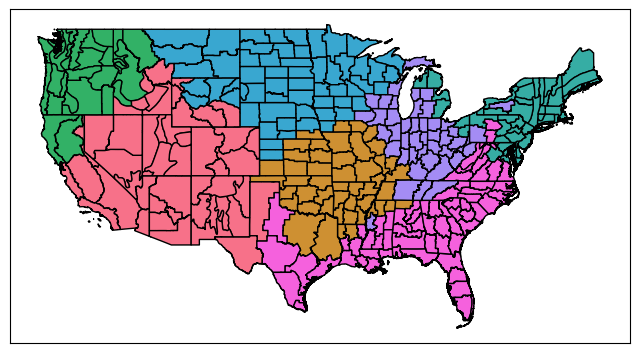

In [9]:
label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        label_array[idx[0]] = kmeans.labels_[i]

gdf['cluster'] = label_array

fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='cluster', cmap=cmap_subset, ax = ax, legend=False, edgecolor = 'black', alpha = 1)

#legend_labels = np.unique(label_array)
#cmap = plt.get_cmap('tab20')
#norm = mcolors.Normalize(vmin=np.min(legend_labels), vmax=np.max(legend_labels))
#patches = [mpatches.Patch(color=cmap(norm(value)), label=f'cluster {int(value)}') for value in legend_labels]
#plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(-0.2, 1), borderaxespad=0.)
 
plt.xticks([])
plt.yticks([]) 
plt.savefig('../figures/climate/kmeans_map.png', bbox_inches = 'tight', dpi = 300)

### IMM / ExKMC

In [21]:
exkmc_tree = ExkmcTree(
    k = k,
    kmeans = kmeans,
    max_leaf_nodes = 7,
    imm = True, 
    feature_labels = feature_labels
)
exkmc_tree.fit(data)
exkmc_data_labels = exkmc_tree.predict(data, leaf_labels = False)
exkmc_data_labels = exkmc_data_labels.astype(int)
exkmc_rules, exkmc_rule_labels = get_decision_paths_with_labels(
    exkmc_tree.root,
    exkmc_data_labels,
    np.unique(exkmc_data_labels)
)

In [40]:
exkmc_rules

[[(<intercluster.rules._node.Node at 0x7fe94f9c7cd0>, 'left'),
  (<intercluster.rules._node.Node at 0x7fe94f9c7520>, None)],
 [(<intercluster.rules._node.Node at 0x7fe94f9c7cd0>, 'right'),
  (<intercluster.rules._node.Node at 0x7fe94f9c7e80>, 'left'),
  (<intercluster.rules._node.Node at 0x7fe94f9c74f0>, 'left'),
  (<intercluster.rules._node.Node at 0x7fe94f9c7d00>, 'left'),
  (<intercluster.rules._node.Node at 0x7fe94f9c7850>, 'left'),
  (<intercluster.rules._node.Node at 0x7fe94f9c7df0>, None)],
 [(<intercluster.rules._node.Node at 0x7fe94f9c7cd0>, 'right'),
  (<intercluster.rules._node.Node at 0x7fe94f9c7e80>, 'left'),
  (<intercluster.rules._node.Node at 0x7fe94f9c74f0>, 'left'),
  (<intercluster.rules._node.Node at 0x7fe94f9c7d00>, 'left'),
  (<intercluster.rules._node.Node at 0x7fe94f9c7850>, 'right'),
  (<intercluster.rules._node.Node at 0x7fe94f9c7a00>, 'left'),
  (<intercluster.rules._node.Node at 0x7fe94f9c73d0>, None)],
 [(<intercluster.rules._node.Node at 0x7fe94f9c7cd0>, '

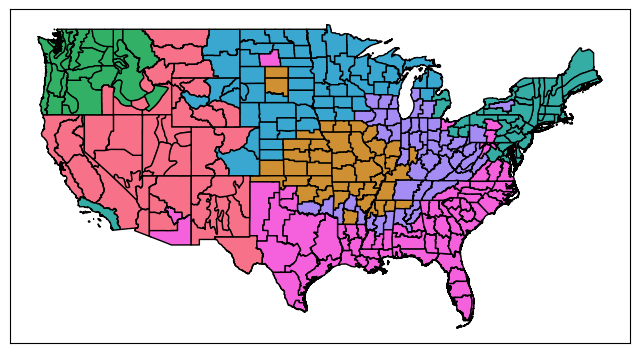

In [22]:
label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        label_array[idx[0]] = exkmc_data_labels[i]

gdf['cluster'] = label_array

fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='cluster', cmap=cmap_subset, ax = ax, legend=False, edgecolor = 'black', alpha = 1)

#legend_labels = np.unique(label_array)
#cmap = plt.get_cmap('tab20')
#norm = mcolors.Normalize(vmin=np.min(legend_labels), vmax=np.max(legend_labels))
#patches = [mpatches.Patch(color=cmap(norm(value)), label=f'cluster {int(value)}') for value in legend_labels]
#plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(-0.2, 1), borderaxespad=0.)
 
plt.xticks([])
plt.yticks([]) 
plt.savefig('../figures/climate/imm_map.png', bbox_inches = 'tight', dpi = 300)

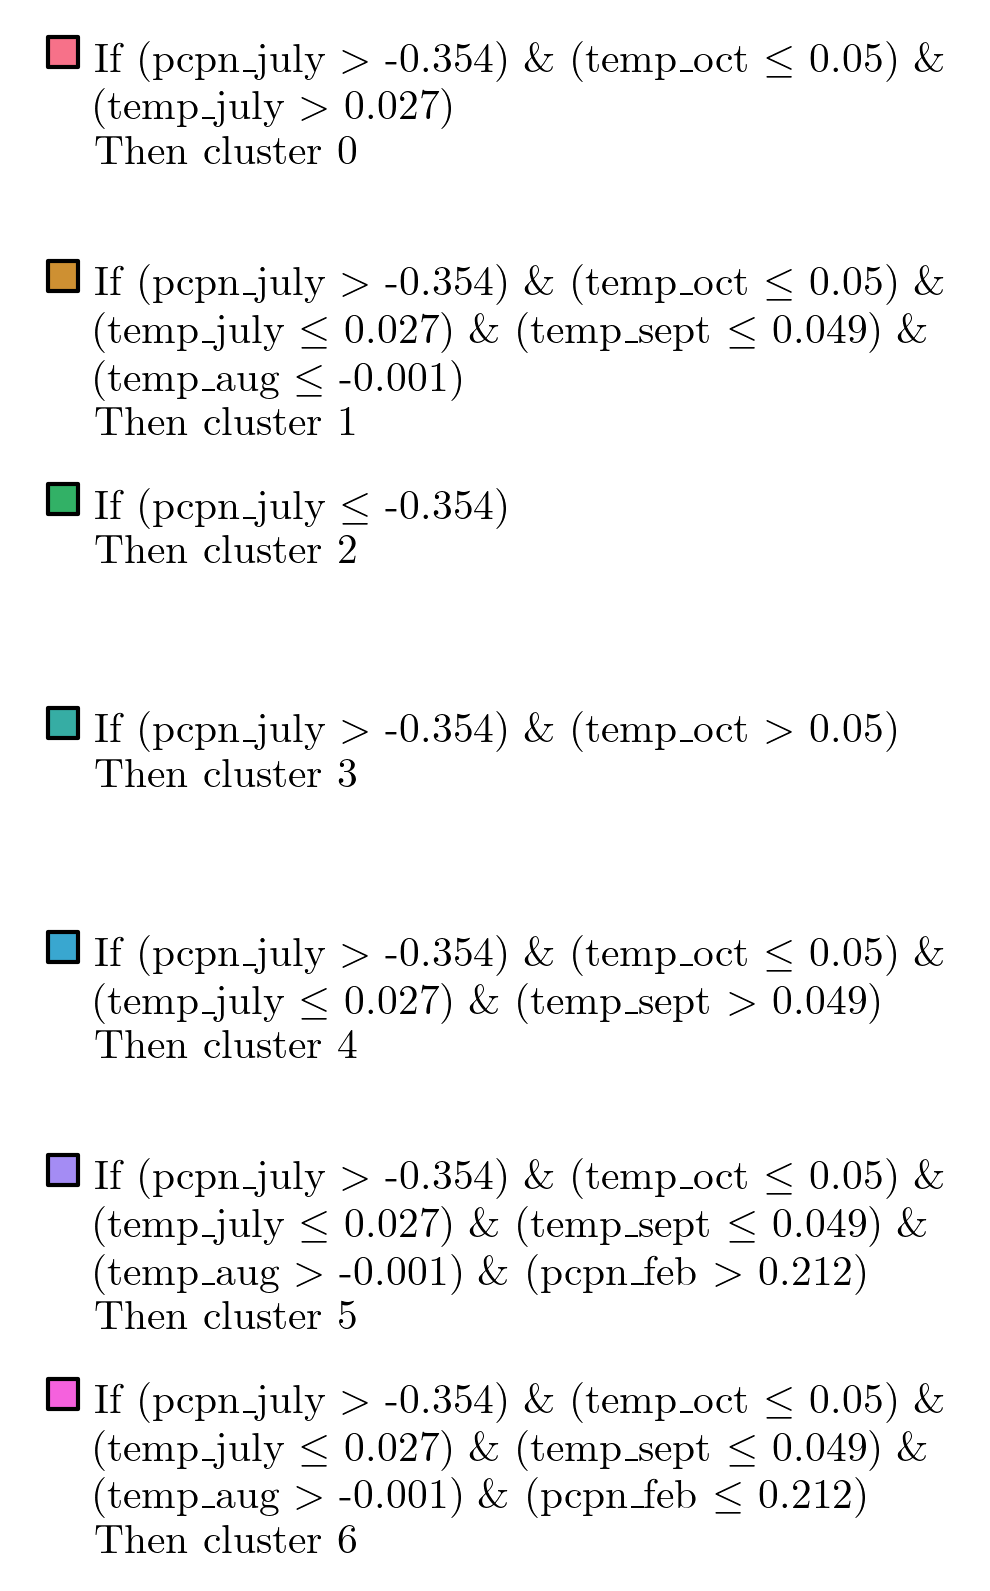

In [39]:
fname = '../figures/climate/imm_rule_list.png'
cluster_colors = {i: cmap_subset(i) for i in range(k)}
plot_decision_set(
    exkmc_rules,
    feature_labels,
    exkmc_rule_labels,
    cluster_colors,
    data_scaler = scaler,
    filename = fname
)

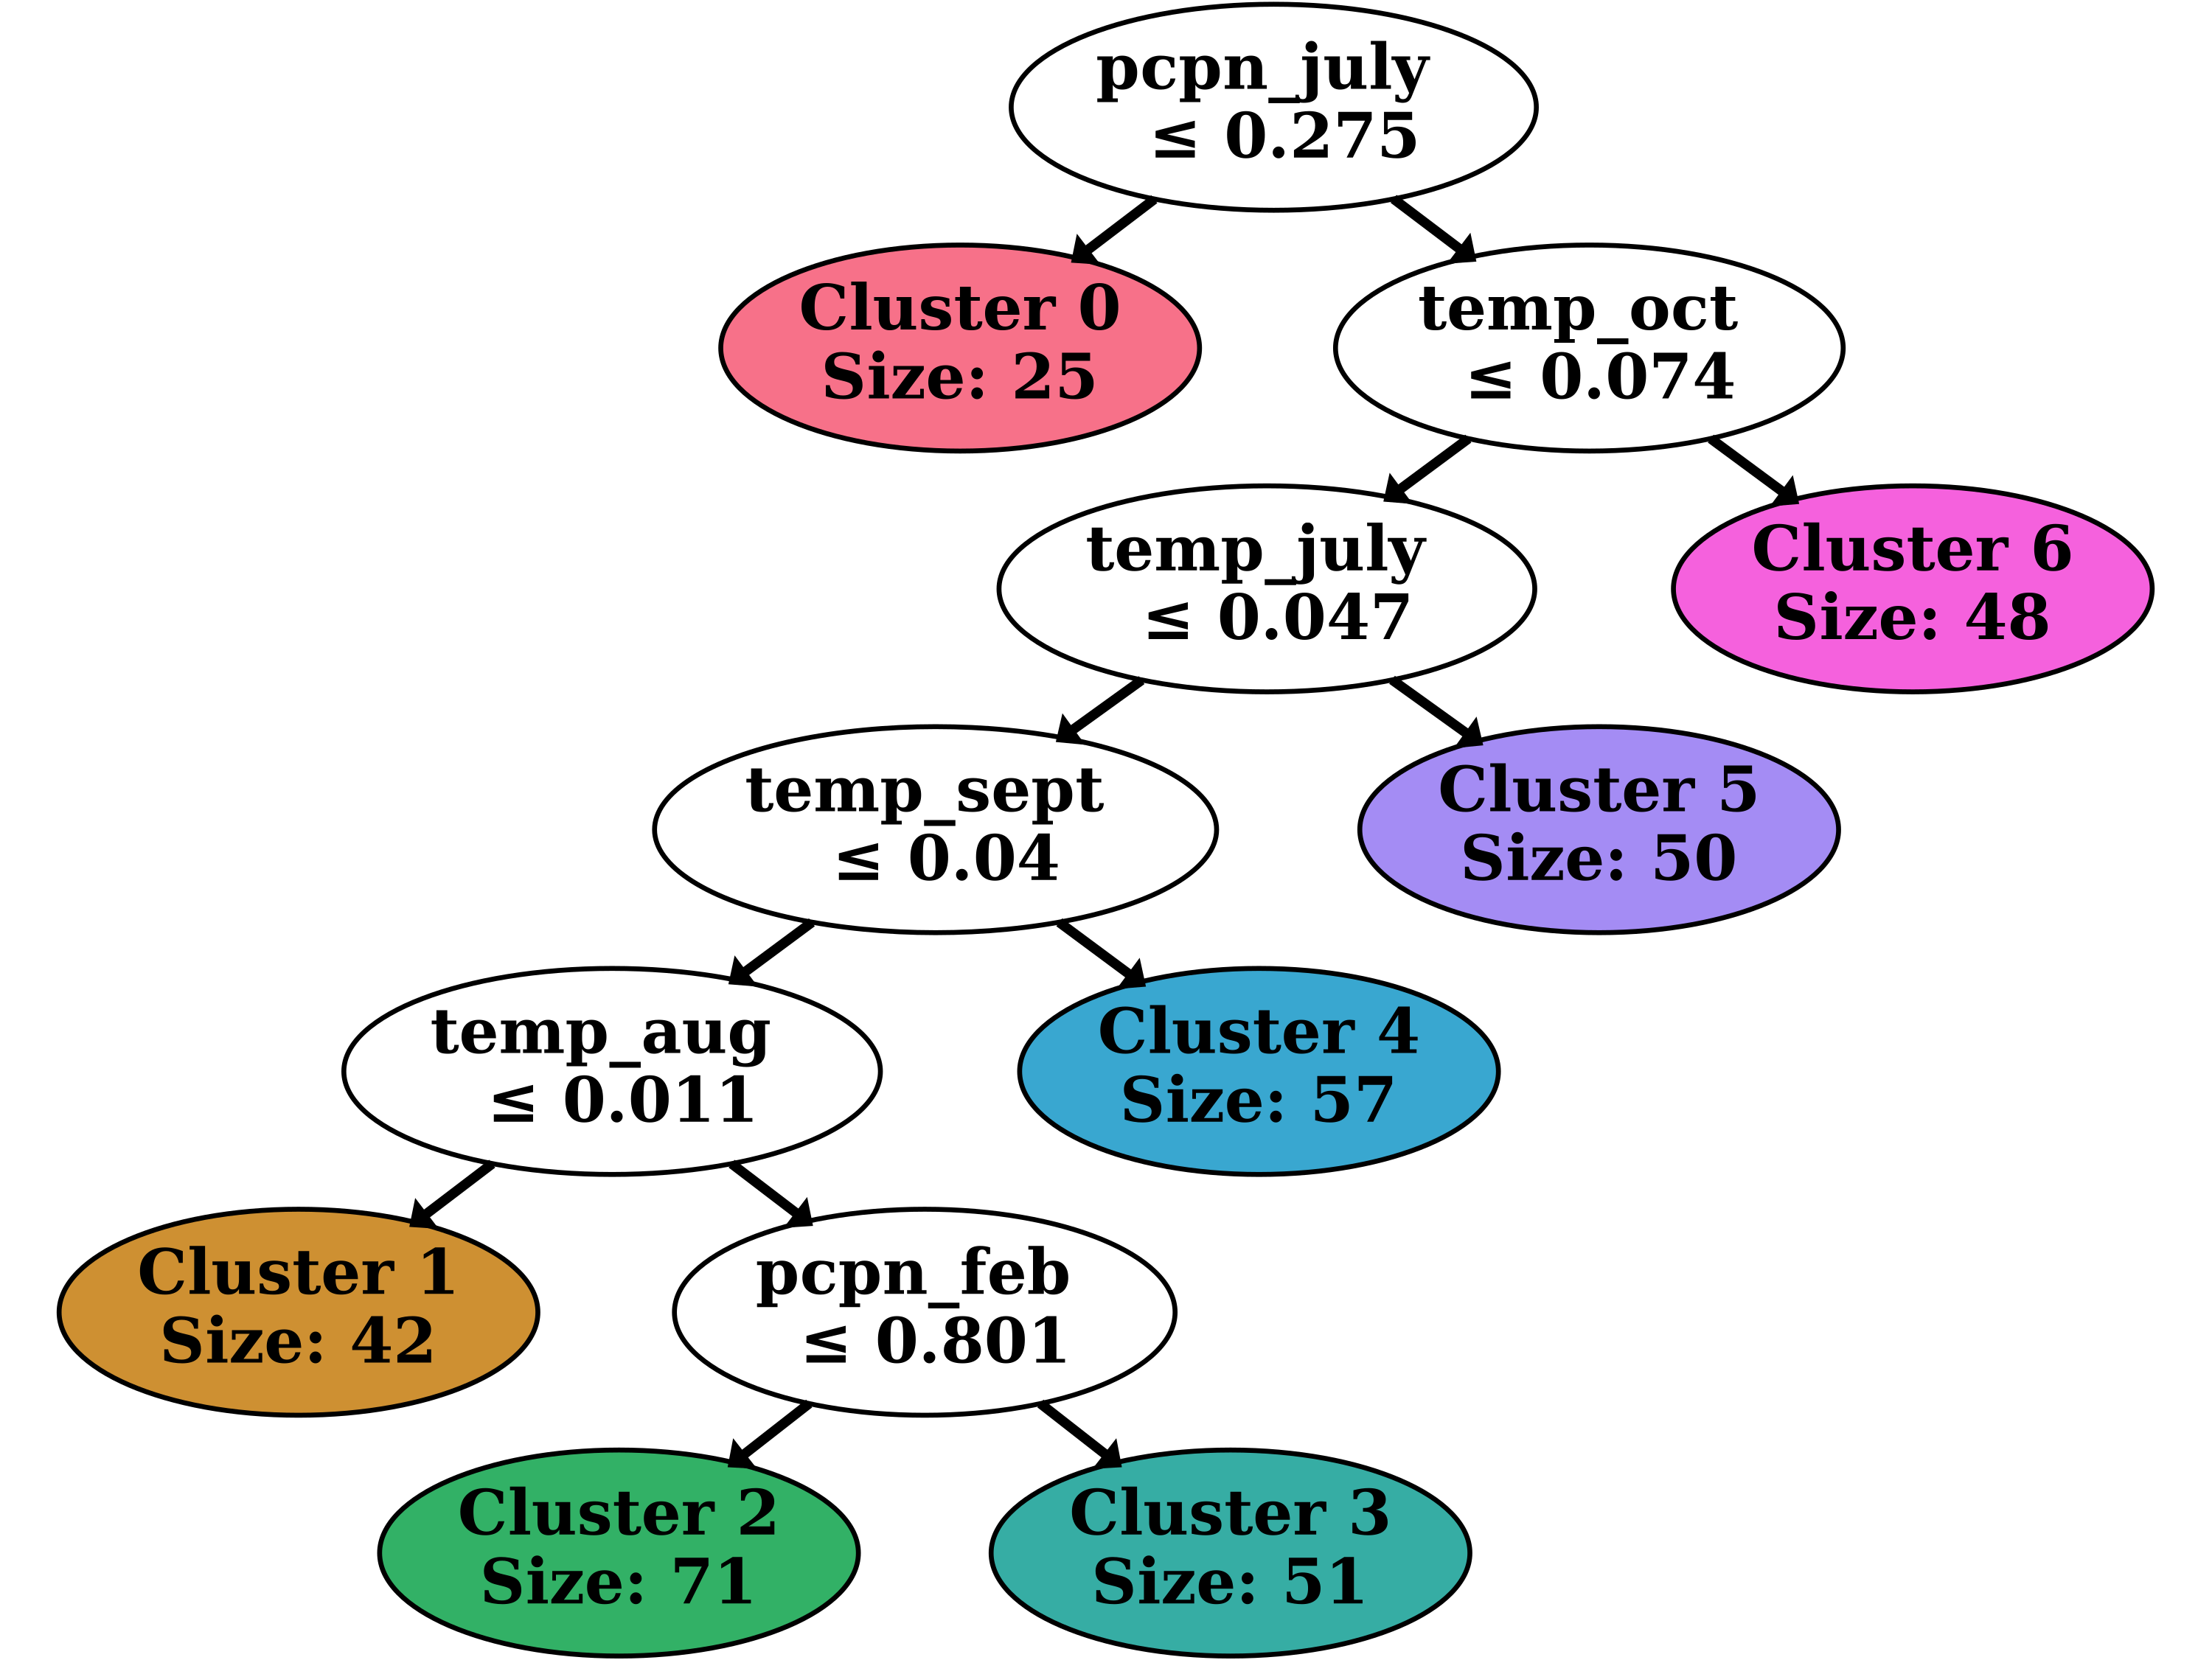

In [44]:
cluster_colors = {i: cmap_subset(i) for i in range(k)}
leaf_colors = {i:mcolors.rgb2hex(cmap_subset(i)) for i in range(k)}
visualize_tree(
    root = exkmc_tree.root,
    feature_labels = feature_labels,
    leaf_colors = leaf_colors,
    data_scaler = scaler,
    cost = False,
    output_file = '../figures/climate/imm_tree.png'
)

In [18]:
tree = ExTree(k, max_leaves = 14, base_tree =  'IMM')
exkmc_labels = tree.fit_predict(data, kmeans=kmeans)
exkmc_assignment = labels_to_assignment(exkmc_labels)
exkmc_centers = tree.all_centers
cost = kmeans_cost(data, exkmc_assignment, exkmc_centers, normalize = True)

### Decision Forest

In [48]:
np.random.seed(918717)

In [88]:
forest_tree_params_exkmc = {
    'k' : k,
    'kmeans' : kmeans,
    'max_leaf_nodes' : k,
    'imm' : True
}

forest_params_exkmc = {
    'tree_model' : ExkmcTree,
    'tree_params' : forest_tree_params_exkmc,
    'num_trees' : 10,
    'max_features' : 24,
    'max_labels' : k,
    'feature_pairings' : [list(range(24))],
    'train_size' : 1
}

forest = DecisionForest(**forest_params_exkmc)
forest.fit(data, kmeans.labels_)

In [49]:
feature_pairings = [list(range(12))] + [list(range(12,24))]

forest_tree_params = {
    'max_depth' : 2
}

forest = DecisionForest(
    SklearnTree,
    tree_params = forest_tree_params, 
    num_trees = 1000,
    max_features = 6,
    max_labels = 1,
    feature_pairings = feature_pairings, 
    train_size = 0.75,
    feature_labels = feature_labels
)
forest.fit(data, kmeans.labels_)

In [89]:
prune_objective = KmeansObjective(
    X = data,
    centers = kmeans.cluster_centers_,
    normalize = True,
    threshold = 1
)

forest.prune(
    q = 7,
    k = 7,
    X = data, 
    y = [[l] for l in kmeans.labels_],
    objective = prune_objective,
    #lambda_search_range = np.linspace(0,len(data),len(data) + 1)
    #lambda_search_range = np.linspace(0,10,101)
    lambda_search_range = [10]
)
prune_predictions = forest.pruned_predict(data, rule_labels = False)

Coverage requirements not met.


/home/kevinq/interpretable/intercluster/pruning/prune.py:188: UserWarning: Coverage requirements not met. Consider adjusting requirements or increasing the search range for lambda.
  warnings.warn(


In [90]:
overlap(labels_to_assignment(prune_predictions, n_labels = k))

1.0

In [91]:
len([l for l in prune_predictions if len(l) == 0])

213

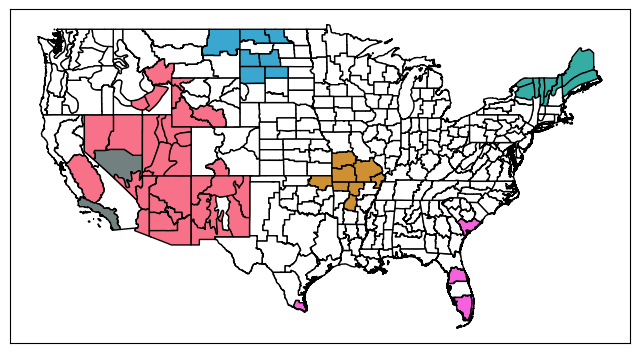

In [87]:
uncover_colors = subset_colors
if len([l for l in prune_predictions if len(l) > 1]) > 0:
    uncover_colors = [overlap_color] + subset_colors
if len([l for l in prune_predictions if len(l) == 0]) > 0:
    uncover_colors = [uncovered_color] + uncover_colors

cmap_subset_uncover = ListedColormap(uncover_colors)

label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        l = prune_predictions[i]
        if len(l) == 1:
            label_array[idx[0]] = l[0]
        elif len(l) > 1:
            label_array[idx[0]] = -1
        else:
            label_array[idx[0]] = -2

gdf['cluster'] = label_array
fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='cluster', cmap=cmap_subset_uncover, ax = ax, legend=False, edgecolor = 'black', alpha = 1)
 
plt.xticks([])
plt.yticks([]) 
#plt.savefig('../figures/climate/forest_map.png', bbox_inches = 'tight', dpi = 300)

In [76]:
# Plots for individual rules:
#fig,ax = plt.subplots(q, 1, figsize = (8,8*q), dpi = 100)
for r in range(7):
    r_labels = np.zeros(len(data)) - 1
    r_labels[rule_covers[selected_rules[r]]] = r
    
    label_array = np.empty(len(gdf))
    label_array[:] = np.nan
    for i,ide in enumerate(climate_change.index):
        idx = gdf.loc[gdf.CLIMDIV == ide].index
        if len(idx) == 1:
            label_array[idx[0]] = r_labels[i]

    fig,ax = plt.subplots(dpi = 100)
    c = selected_rule_labels[r]
    new_cmap = ["white", cmap_subset(c)]
    new_cmap = ListedColormap(new_cmap)
    gdf['cluster'] = label_array
    gdf.plot(column='cluster', cmap=new_cmap, ax = ax, legend=False, edgecolor = 'black', alpha = 1)
    plt.xticks([])
    plt.yticks([]) 
    #plt.savefig('../figures/decision_sets/rule_' + str(r) + '.png', bbox_inches = 'tight', dpi = 300)

NameError: name 'rule_covers' is not defined

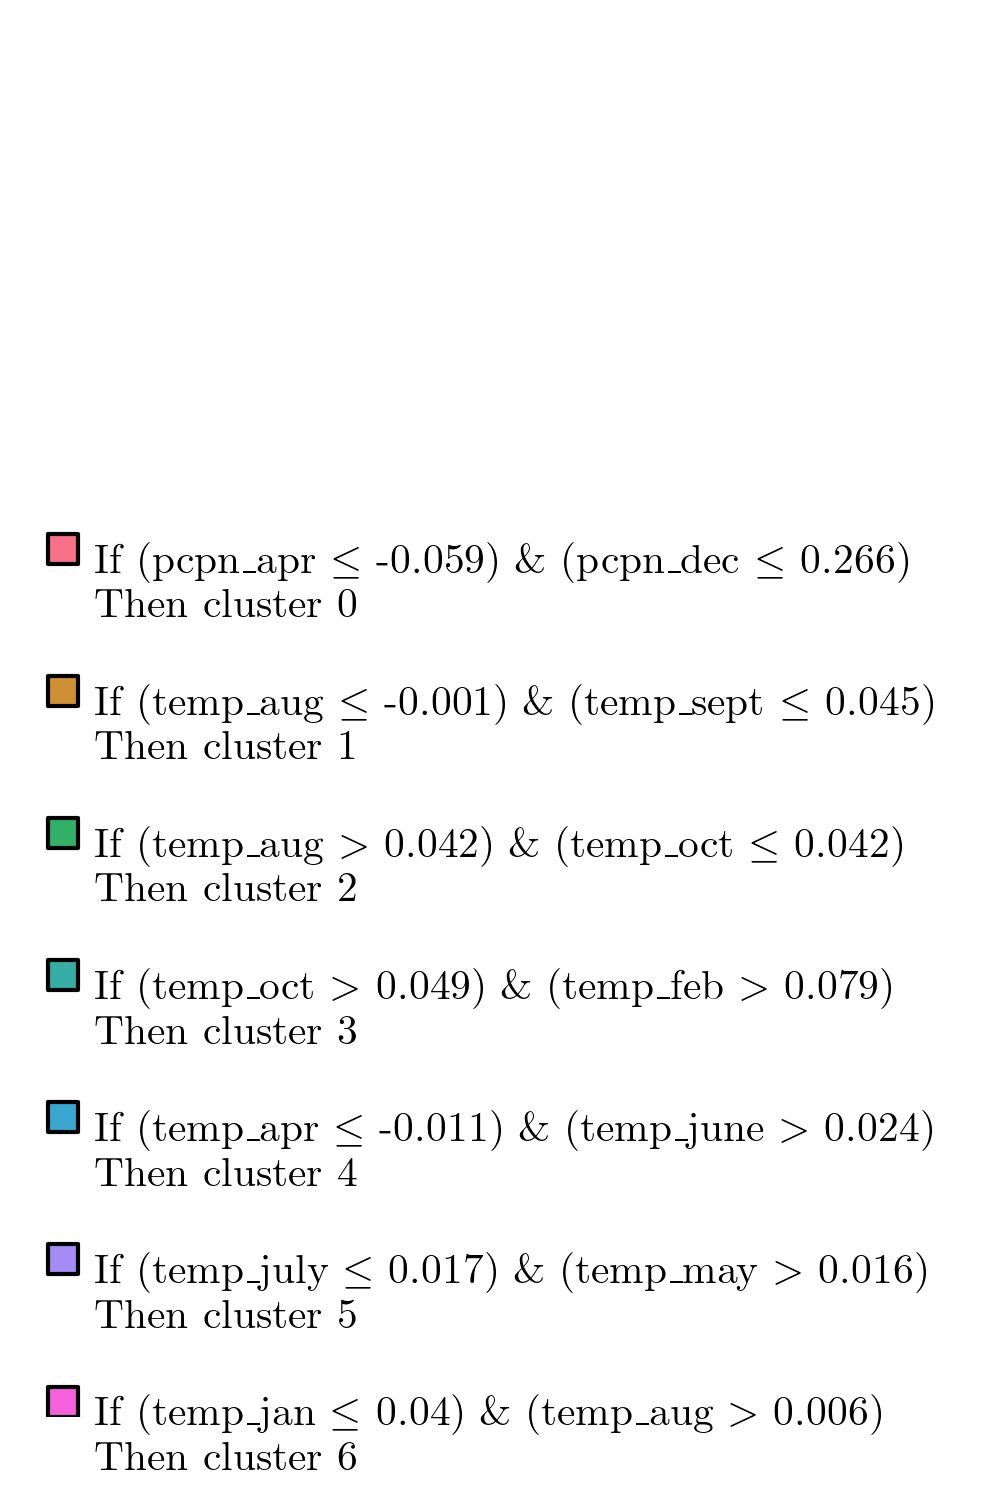

In [67]:
fname = '../figures/climate/forest_rule_list.png'
#fname = None
cluster_colors = {i: cmap_subset(i) for i in range(k)}
plot_decision_set(
    [forest.decision_set[i] for i in forest.pruned_indices],
    feature_labels,
    [forest.decision_set_labels[i] for i in forest.pruned_indices],
    cluster_colors,
    data_scaler = scaler,
    filename = fname
)

## Voronoi Sets

In [16]:
feature_pairings = [list(range(12))] + [list(range(12,24))]

vor = VoronoiSet(
    centers = kmeans.cluster_centers_, 
    num_sets = 1000,
    num_conditions = 2,
    feature_pairings = feature_pairings, 
    feature_labels = feature_labels
)
vor.fit(data, kmeans.labels_)

In [17]:
prune_objective = KmeansObjective(
    X = data,
    centers = kmeans.cluster_centers_,
    normalize = True,
    threshold = 0.8
)

vor.prune(
    q = 7,
    k = 7,
    X = data, 
    y = [[l] for l in kmeans.labels_],
    objective = prune_objective,
    lambda_search_range = np.linspace(0,10,101)
    #lambda_search_range = [10]
)
prune_predictions = vor.pruned_predict(data, rule_labels = False)

([], [])

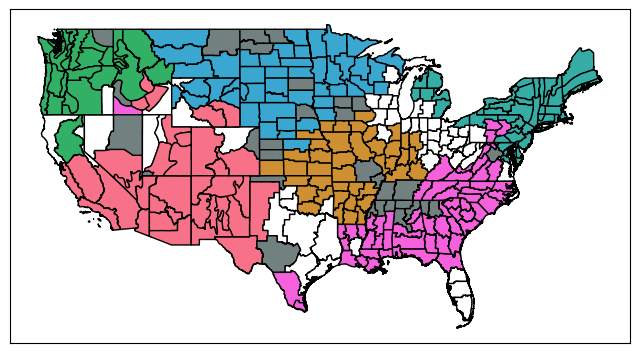

In [18]:
uncover_colors = subset_colors
if len([l for l in prune_predictions if len(l) > 1]) > 0:
    uncover_colors = [overlap_color] + subset_colors
if len([l for l in prune_predictions if len(l) == 0]) > 0:
    uncover_colors = [uncovered_color] + uncover_colors

cmap_subset_uncover = ListedColormap(uncover_colors)

label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        l = prune_predictions[i]
        if len(l) == 1:
            label_array[idx[0]] = l[0]
        elif len(l) > 1:
            label_array[idx[0]] = -1
        else:
            label_array[idx[0]] = -2

gdf['cluster'] = label_array
fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='cluster', cmap=cmap_subset_uncover, ax = ax, legend=False, edgecolor = 'black', alpha = 1)
 
plt.xticks([])
plt.yticks([]) 
#plt.savefig('../figures/decision_sets/kmeans.png', bbox_inches = 'tight', dpi = 300)

TypeError: 'LinearCondition' object is not subscriptable

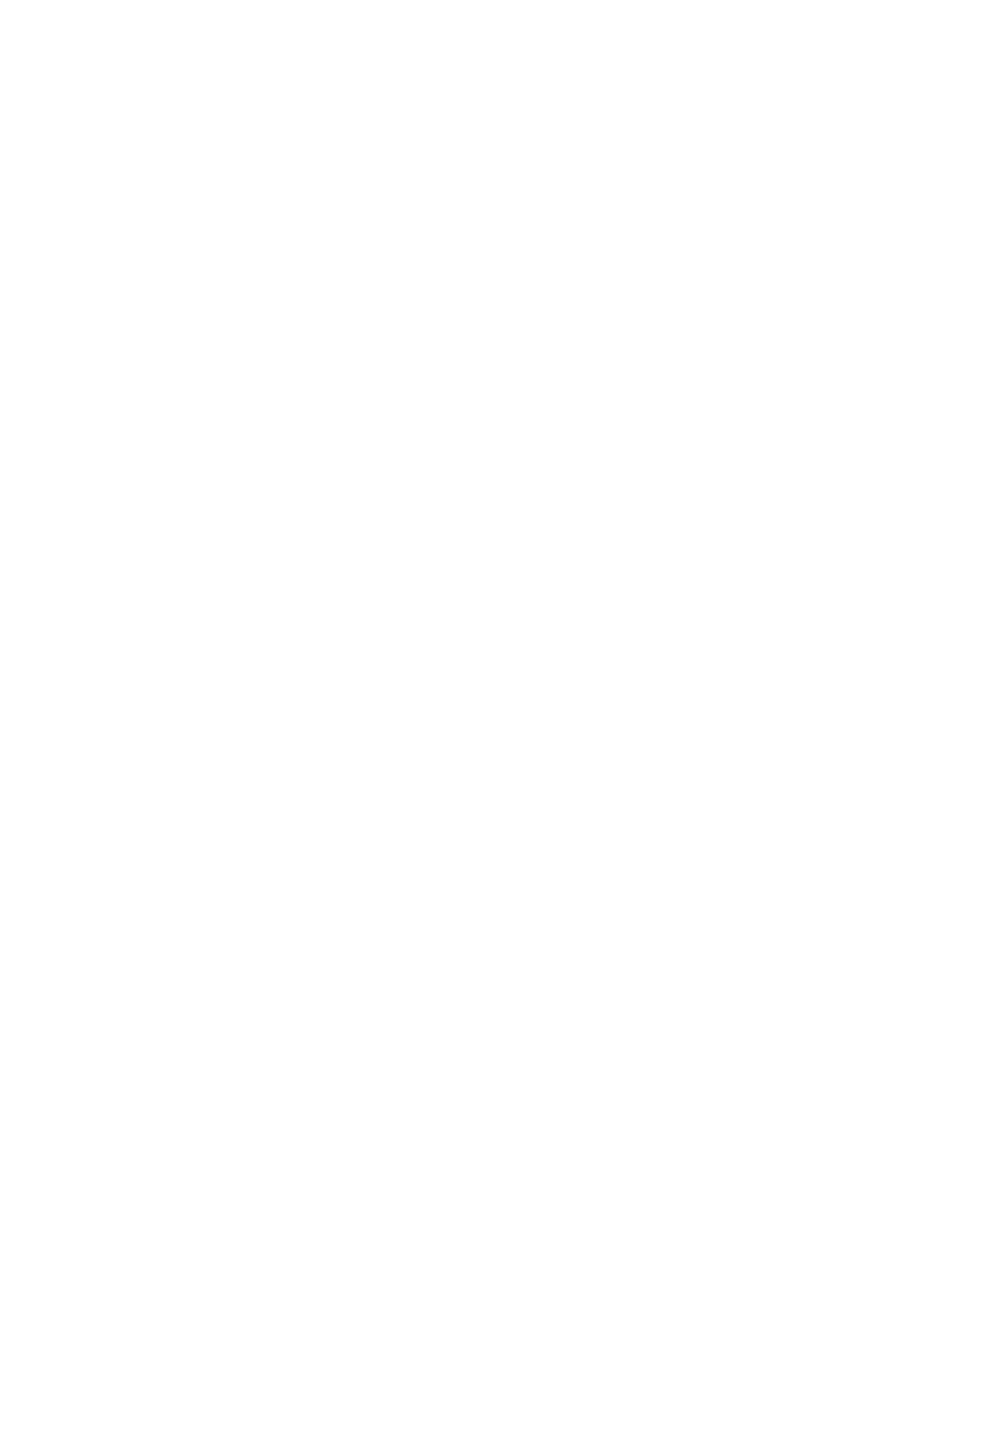

In [15]:
#fname = '../figures/climate/forest_rule_list.png'
fname = None
cluster_colors = {i: cmap_subset(i) for i in range(k)}
plot_decision_set(
    [vor.decision_set[i] for i in vor.pruned_indices],
    feature_labels,
    [vor.decision_set_labels[i] for i in vor.pruned_indices],
    cluster_colors,
    data_scaler = scaler,
    filename = fname
)